# Data Exploration Project: Tom & Jerry Image Classification

### Data Understanding

In [1]:
import pandas as pd

df = pd.read_csv("data/ground_truth.csv")
df.head()

,filename,tom,jerry
0,frame0.jpg,0,0
1,frame1.jpg,0,0
2,frame2.jpg,0,0
3,frame3.jpg,0,0
4,frame4.jpg,0,0


In [2]:
df["filename"].nunique()

5478

Arbeitsschritte:
- Bilder laden
- Bilder in Tensoren umwandeln (RGB-Werte, Pixel x Pixelevtl. irgendwie zu kleinerer Pixelanzahl downscalen falls nötig, und auch normalisieren (vor allem RGB Werte))
- Train/Test Split
- Modelllogik implementieren mit diesen ganzen verschiedenen Layern vom CNN, Aktivierungsfunktion auswählen
- Training (nochmal auf Konzepte Loss-Function, Backpropagation und was es da sonst noch alles gibt schauen und überlegen ob das Sinn macht)
- Evaluation / Auswertung
- Modell speichern für Wiederverwendbarkeit
- evtl. irgendwas überlegen für Hyperparametertuning und Overfitting


In [41]:
import pandas as pd

df = pd.read_csv("data/ground_truth.csv")

# Create new row "class" based on binary combinations
def get_class(row):
    if row['tom'] == 1 and row['jerry'] == 1:
        return 'tom_and_jerry'
    elif row['tom'] == 1 and row['jerry'] == 0:
        return 'tom'
    elif row['tom'] == 0 and row['jerry'] == 1:
        return 'jerry'
    else:
        return 'none' 

df['class'] = df.apply(get_class, axis=1)

# print class distribution
print("Class Distribution:")
print(df['class'].value_counts())

# save as new csv
df.drop(columns=["tom", "jerry"], inplace=True)
df.to_csv("data/ground_truth_w_class.csv", index=False)

Class Distribution:
class
tom              1930
none             1528
jerry            1240
tom_and_jerry     780
Name: count, dtype: int64


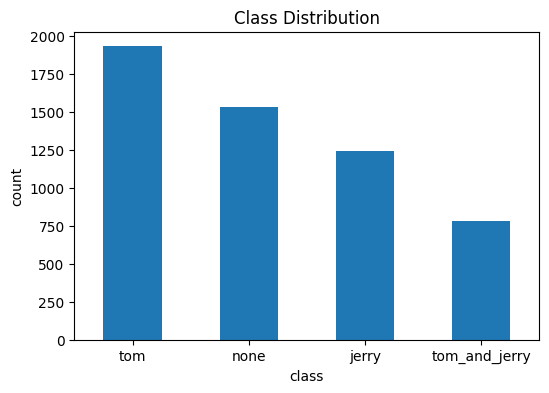

In [42]:
import matplotlib.pyplot as plt

# bar chat for class distribution
df['class'].value_counts().plot(kind='bar', figsize=(6,4), rot=0)
plt.title("Class Distribution")
plt.xlabel("class")
plt.ylabel("count")
plt.show()

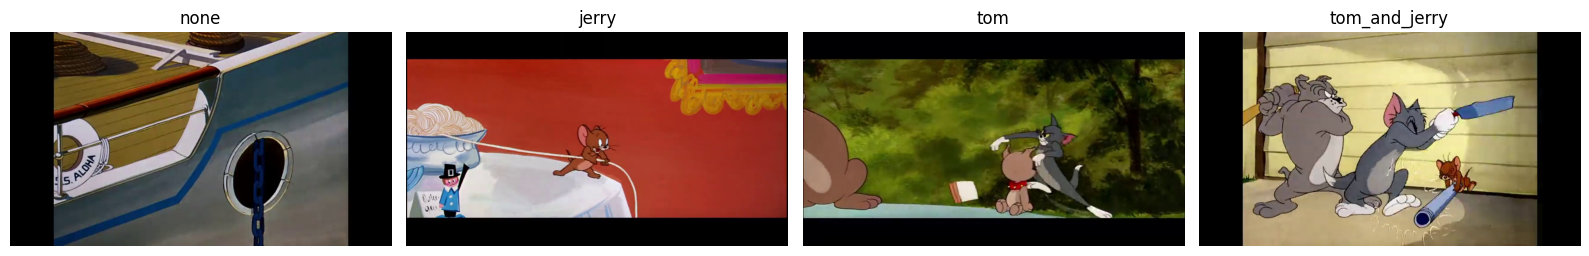

In [47]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

df = pd.read_csv("data/ground_truth_w_class.csv")
unique_classes = df['class'].unique()

# create subplot with as many columns as there are classes
fig, axes = plt.subplots(1, len(unique_classes), figsize=(4 * len(unique_classes), 4))

for i, cls in enumerate(unique_classes):
    class_samples = df[df['class'] == cls]
    # select one random row for each class
    sample_row = class_samples.sample(1).iloc[0]

    # build image path
    img_path = os.path.join("data/images", cls, sample_row['filename'])

    # open and show image
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis('off')

plt.tight_layout()
plt.show()



Class Distribution of challenging images:
folder
tom      18
jerry    14
Name: count, dtype: int64


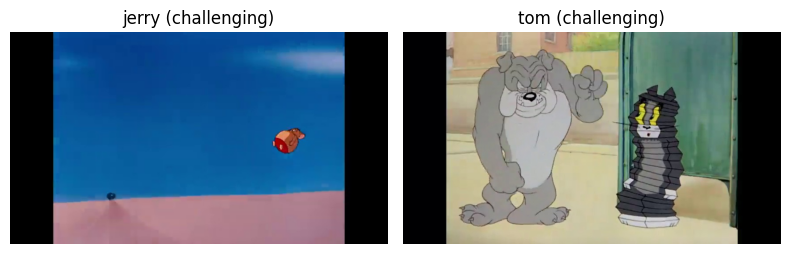

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

df_challenges = pd.read_csv("data/challenges.csv")

print("Class Distribution of challenging images:")
print(df_challenges['folder'].value_counts())

unique_classes = df_challenges['folder'].unique()
fig, axes = plt.subplots(1, len(unique_classes), figsize=(4 * len(unique_classes), 4))

for i, cls in enumerate(unique_classes):
    # Select random row from each class
    sample_row = df_challenges[df_challenges['folder'] == cls].sample(1).iloc[0]
    img_path = os.path.join("data/images", cls, sample_row['image_name'])

    # open and show image
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f"{cls} (challenging)")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Overview of Image Sizes in Dataset:
   Width  Height  Count
0    854     480   4195
1   1280     720   1283


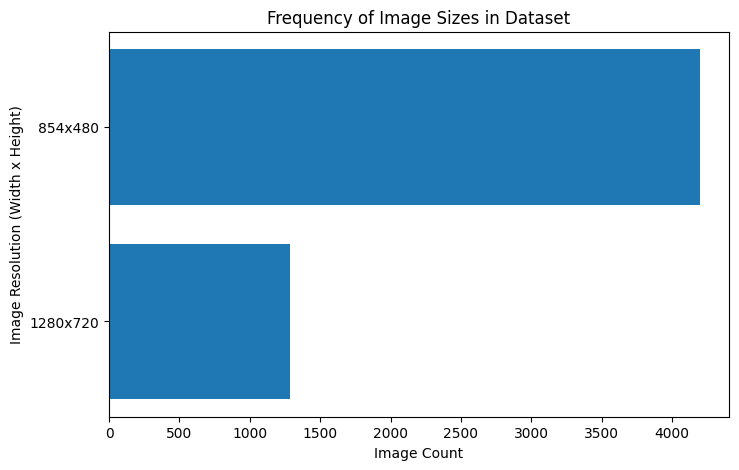

In [51]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

# base directory of images
image_dir = "data/images/"

image_sizes = []

# iterate through all sub-folders
for folder in os.listdir(image_dir):
    folder_path = os.path.join(image_dir, folder)
    
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)

            try:
                with Image.open(img_path) as img:
                    image_sizes.append(img.size)  # saves (width, height)-tuple
            except Exception as e:
                print(f"Fehler beim Laden von {img_path}: {e}")

# convert to dataframe
df_sizes = pd.DataFrame(image_sizes, columns=["Width", "Height"])

# calculate absolute frequency of all image sizes
unique_sizes = df_sizes.value_counts().reset_index()
unique_sizes.columns = ["Width", "Height", "Count"]

# print table
print("\nOverview of Image Sizes in Dataset:")
print(unique_sizes)

# visualization of table values
plt.figure(figsize=(8,5))
plt.barh(
    [f"{w}x{h}" for w, h in unique_sizes[["Width", "Height"]].values], 
    unique_sizes["Count"]
)
plt.xlabel("Image Count")
plt.ylabel("Image Resolution (Width x Height)")
plt.title("Frequency of Image Sizes in Dataset")
plt.gca().invert_yaxis()
plt.show()



### Data Preparation

In [54]:
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Setup
IMAGE_DIRECTORY = "data/images"
img_height, img_width = 224, 224  
batch_size = 32
test_split = 0.2  # 80% Train, 20% Test
random_seed = 42  # for reproducability

# define transform for training data
# incorporating data augmentation techniques to prevent overfitting
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(p=0.25),  # 25% possibility of horizontal mirroring
    transforms.RandomApply([transforms.RandomRotation(15)], p=0.25),  # 25% possibility of rotation between [-15,15]°
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # random percentual color adjustments
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# transform for test set (no augmentation here)
test_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

# create full dataset with different transforms
full_dataset = datasets.ImageFolder(root=IMAGE_DIRECTORY)
train_indices, test_indices = train_test_split(
    list(range(len(full_dataset))),
    test_size=test_split,
    random_state=random_seed,
    shuffle=True
)

# create subset with respective transform-pipelines
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

# apply transform
train_dataset.dataset = datasets.ImageFolder(root=IMAGE_DIRECTORY, transform=train_transform)
test_dataset.dataset = datasets.ImageFolder(root=IMAGE_DIRECTORY, transform=test_transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# print split info
print(f"Total Dataset   : {len(full_dataset)}")
print(f"Train Dataset   : {len(train_dataset)}")
print(f"Test Set  : {len(test_dataset)}")

# investigate shape of one input batch
batch_images, batch_labels = next(iter(train_loader))
print(f"Shape of batch images: {batch_images.shape}")  
# schema: (Batch_size, RGB Channels, Height, Width)

Total Dataset   : 5478
Train Dataset   : 4382
Test Set  : 1096
Shape of batch images: torch.Size([32, 3, 224, 224])


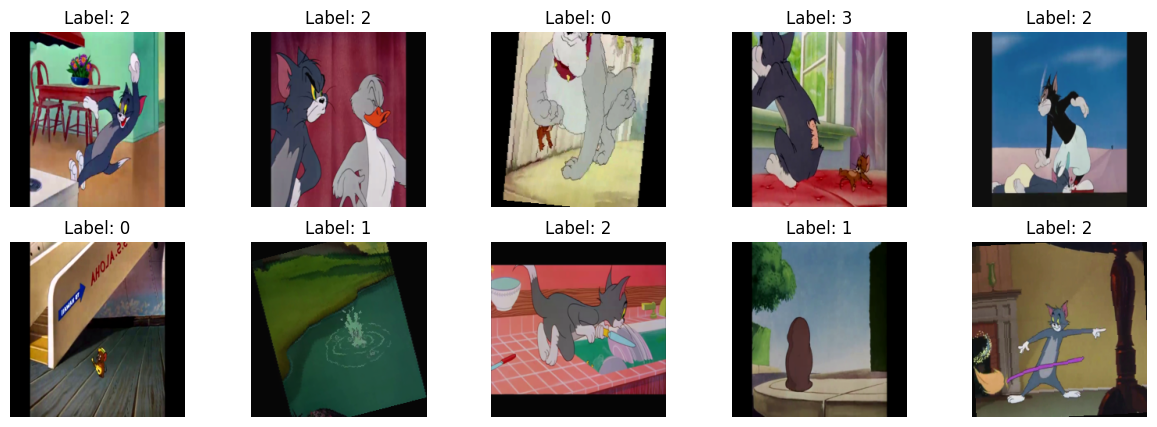

In [56]:
import matplotlib.pyplot as plt
import torch

# function to reset normalization (for visualization purposes)
def denormalize(tensor, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    mean = torch.tensor(mean).view(1, 3, 1, 1)  # adjust shape
    std = torch.tensor(std).view(1, 3, 1, 1)
    return tensor * std + mean  # reverse normalization 

# load sample batch from dataloader
batch_images, batch_labels = next(iter(train_loader))

# denormalize images
batch_images = denormalize(batch_images)

# visualizing 10 images from a batch
plt.figure(figsize=(15, 5))
for i in range(10): 
    ax = plt.subplot(2, 5, i + 1)
    image_np = batch_images[i].permute(1, 2, 0).numpy() 
    
    plt.imshow(image_np.clip(0, 1)) 
    plt.title(f"Label: {batch_labels[i].item()}")
    plt.axis("off")

plt.show()


In [58]:
# print assignment of numerical labels to textual labels
class_to_idx = full_dataset.class_to_idx
print("class_to_idx:", class_to_idx)

class_to_idx: {'jerry': 0, 'none': 1, 'tom': 2, 'tom_and_jerry': 3}


In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# implementation of model-logic
class TomAndJerryCNN(nn.Module):
    def __init__(self, num_classes, img_height=224, img_width=224):
        super(TomAndJerryCNN, self).__init__()
        
        # Convolution blocks
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Pooling + Dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout_conv = nn.Dropout2d(p=0.3)  # Dropout after conv layers

        # calculation of size for fc1:
        # after 3x MaxPool with kernel=2, stride=2 -> image_size / 8
        # With a resolution of 224x224 -> 224/8 = 28 -> 64 * 28 * 28
        conv_output_size = 64 * (img_height // 8) * (img_width // 8)
        
        self.fc1 = nn.Linear(conv_output_size, 128)
        self.dropout_fc = nn.Dropout(p=0.5)  # Dropout in fully-connected part
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # Convolution-Block 1
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        # Convolution-Block 2
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # Convolution-Block 3
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # Dropout after Convolution-Layers
        x = self.dropout_conv(x)
        
        # Flatten
        x = torch.flatten(x, start_dim=1)
        
        # Fully-Connected
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        
        x = self.fc2(x)
        return x


In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Use Metal Performance Shaders (MPS) if available (hardware-dependent)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Current device:", device)

# 1) Initialize the model
num_classes = 4  
model = TomAndJerryCNN(num_classes=num_classes, img_height=224, img_width=224)
model.to(device)

# 2) Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# 3) Learning Rate Scheduler
#   - step_size=5: reduce LR every 5 epochs
#   - gamma=0.5: multiply LR by 0.5 (i.e., halve it)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# 5) Training hyperparameters
num_epochs = 15
print_interval = 1  

train_acc_history = []
test_acc_history = []
train_loss_history = []
test_loss_history = []

for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    
    # Store training loss and accuracy
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)

    # --- EVALUATION (test/validation) ---
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
    
    test_loss /= test_total
    test_acc = 100.0 * test_correct / test_total

    # Store test loss and accuracy
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    
    # Print results
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%\n")
    
    # Learning Rate Adjustment
    scheduler.step()


Current device: mps
Epoch [1/15] Train Loss: 1.3125, Train Acc: 37.68% | Test Loss: 1.2204, Test Acc: 41.88%

Epoch [2/15] Train Loss: 1.1519, Train Acc: 50.00% | Test Loss: 0.9649, Test Acc: 60.68%

Epoch [3/15] Train Loss: 0.9780, Train Acc: 59.79% | Test Loss: 0.8150, Test Acc: 67.61%

Epoch [4/15] Train Loss: 0.8547, Train Acc: 65.81% | Test Loss: 0.6934, Test Acc: 72.17%

Epoch [5/15] Train Loss: 0.7699, Train Acc: 69.49% | Test Loss: 0.6222, Test Acc: 76.28%

Epoch [6/15] Train Loss: 0.6433, Train Acc: 75.65% | Test Loss: 0.5531, Test Acc: 79.20%

Epoch [7/15] Train Loss: 0.5675, Train Acc: 78.41% | Test Loss: 0.5130, Test Acc: 80.47%

Epoch [8/15] Train Loss: 0.5384, Train Acc: 79.69% | Test Loss: 0.4680, Test Acc: 83.39%

Epoch [9/15] Train Loss: 0.4918, Train Acc: 80.69% | Test Loss: 0.4434, Test Acc: 84.85%

Epoch [10/15] Train Loss: 0.4584, Train Acc: 82.91% | Test Loss: 0.4176, Test Acc: 84.49%

Epoch [11/15] Train Loss: 0.4271, Train Acc: 84.09% | Test Loss: 0.4063, Test A

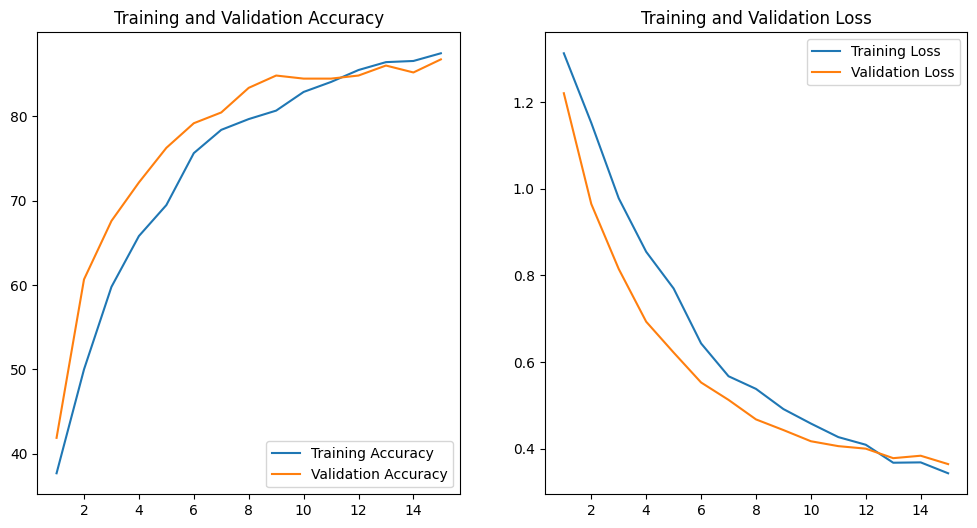

In [72]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_acc_history) + 1)

plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_history, label='Training Accuracy')
plt.plot(epochs_range, test_acc_history, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_history, label='Training Loss')
plt.plot(epochs_range, test_loss_history, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()
